The following dataset is from a GEANT based simulation of electron-proton inelastic scattering measured by a particle detector system.

We will be using Decision Trees and Random Forests to classify particles based on feature data measured by the detector. As the author of the data notes, zeros are in some columns either becuase of detector malfunction or lack of geometric data.  In order to rule out a false sense of accuracy, I will drop the columns where zeors are prevelant (nphe, ein, eout). 


The ultamite goal is to take data measured by the detector (and new features that can be extrapolated from the given data) and train the algorithms on that data in order to make future predictions. Then, after the new detector data comes in, we already have a trained model that can give us a decently accurate prediction on what the particle is.

The features we will have are p (momentum) in units of GeV/c, Theta (angle) in units of radians, and Beta (angle) in units of radians.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("pid-5M.csv")
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [3]:
df = df.drop("nphe", axis = 1)
df = df.drop("ein", axis = 1)
df = df.drop("eout", axis = 1)
df.head()

,id,p,theta,beta
0,211,0.780041,1.081480,0.989962
1,211,0.260929,0.778892,0.902450
2,2212,0.773022,0.185953,0.642428
3,211,0.476997,0.445561,0.951471
4,2212,2.123290,0.337332,0.908652


In [4]:
df.shape

(5000000, 4)

We can add another column with each particle's de Broglie wavelength. By taking hc/pc, we can get the de Broglie wavelength in nm. To make the numbers a little more like the numbers we have, we can then multiply each de Broglie wavelength by 1,000,000 in order for the lengths to be in femptometers (fm).

Note that p (momentum) already is in units of GeV/c. So multiplying p by c just gives us a number in units of GeV.

In [5]:
df["de_Broglie"] = ""
df.head()

,id,p,theta,beta,de_Broglie
0,211,0.780041,1.081480,0.989962,
1,211,0.260929,0.778892,0.902450,
2,2212,0.773022,0.185953,0.642428,
3,211,0.476997,0.445561,0.951471,
4,2212,2.123290,0.337332,0.908652,


In [6]:
h_c = .00000123984 #hc planck's constant, units GeV*nm

def lamda(p):
    return h_c/p

In [7]:
wavelengths = []
for i in range(df["id"].count()):
    x = df["p"][i]
    y = lamda(x)
    wavelengths.append(y)

In [8]:
#Putting wavelengths in units of fm
new_wavelengths = []
for i in range(len(wavelengths)):
    x = wavelengths[i]
    new_wavelengths.append(x*1000000)

In [9]:
df["de_Broglie"] = new_wavelengths
df.head()

,id,p,theta,beta,de_Broglie
0,211,0.780041,1.081480,0.989962,1.589455
1,211,0.260929,0.778892,0.902450,4.751637
2,2212,0.773022,0.185953,0.642428,1.603887
3,211,0.476997,0.445561,0.951471,2.599262
4,2212,2.123290,0.337332,0.908652,0.583924


In [10]:
df.describe()

,id,p,theta,beta,de_Broglie
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,9.941839e+02,1.230053e+00,4.889321e-01,8.995796e-01,1.514775e+00
std,9.724034e+02,7.414895e-01,2.942161e-01,1.132321e-01,1.088758e+00
min,-1.100000e+01,2.101170e-01,9.222140e-02,5.500010e-01,2.345095e-01
25%,2.110000e+02,6.657510e-01,2.817420e-01,8.378760e-01,7.515776e-01
50%,2.110000e+02,1.066150e+00,4.048670e-01,9.461940e-01,1.162913e+00
75%,2.212000e+03,1.649650e+00,6.117800e-01,9.855910e-01,1.862318e+00
max,2.212000e+03,5.286950e+00,2.219270e+00,1.499590e+00,5.900712e+00


Let's see how unbalanced the data is. If there are particles that show up a lot less than others, we need to duplicate some rows.

ID's: Positron (-11), Pion (211), Kaon (321), Proton (2212)

In [12]:
positron_data = []
pion_data = []
kaon_data = []
proton_data = []

for i in range(df["id"].count()):
    if df["id"][i] == -11:
        positron_data.append(df.loc[i])
    if df["id"][i] == 211:
        pion_data.append(df.loc[i])
    if df["id"][i] == 321:
        kaon_data.append(df.loc[i])
    if df["id"][i] == 2212:
        proton_data.append(df.loc[i])

In [13]:
print(len(positron_data))
print(len(pion_data))
print(len(kaon_data))
print(len(proton_data))

14847
2806833
232471
1945849


The number of positrons and kaons are vastly outnumbered by the amount of pions and protons. Before we do anything about that, let's look at some distributions and a correlation matrix.

Text(0.5,1,'Momentum Distribution for all Particles')

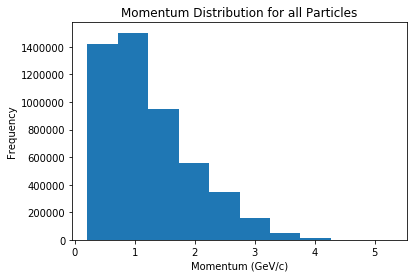

In [14]:
#Momentum Histogram
momentum = np.array(df["p"])
plt.hist(momentum, range = (momentum.min(), momentum.max()))
plt.xlabel("Momentum (GeV/c)")
plt.ylabel("Frequency")
plt.title("Momentum Distribution for all Particles")

Text(0.5,1,'Theta Distribution for all Particles')

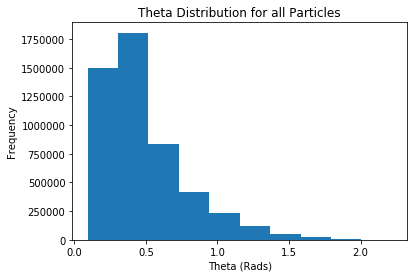

In [15]:
#Theta Histogram
theta = np.array(df["theta"])
plt.hist(theta, range = (theta.min(), theta.max()))
plt.xlabel("Theta (Rads)")
plt.ylabel("Frequency")
plt.title("Theta Distribution for all Particles")

Text(0.5,1,'Beta Distribution for all Particles')

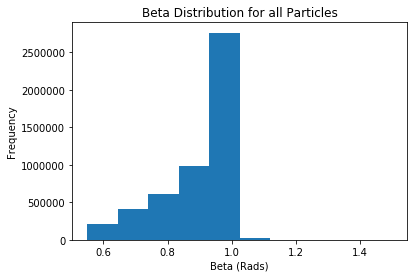

In [17]:
#Beta Histogram
beta = np.array(df["beta"])
plt.hist(beta, range = (beta.min(), beta.max()))
plt.xlabel("Beta (Rads)")
plt.ylabel("Frequency")
plt.title("Beta Distribution for all Particles")

Text(0.5,1,'de Broglie Wavelength Distribution for all Particles')

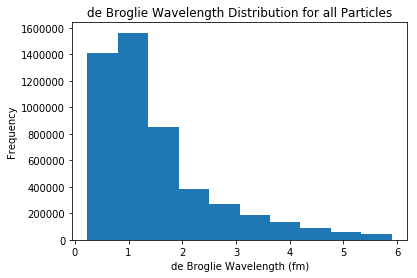

In [18]:
#de Broglie Histogram
de_broglie = np.array(df["de_Broglie"])
plt.hist(de_broglie, range = (de_broglie.min(), de_broglie.max()))
plt.xlabel("de Broglie Wavelength (fm)")
plt.ylabel("Frequency")
plt.title("de Broglie Wavelength Distribution for all Particles")

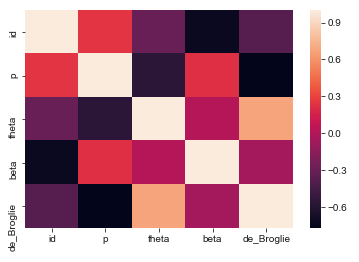

In [19]:
#Heatmap of features

import seaborn as sns
sns.heatmap(df[["id", "p", "theta", "beta", "de_Broglie"]].corr())
sns.set(style = 'dark')

To make the amount of positron ids and kaon ids on par with the amount of pion and proton ids, we will duplicate rows that correspond to positrons and kaons. 

The first step will be to create arrays for each individual particle. We will duplicate the ones that need duplicated (positrons and kaons) and then create individual dataframes for each of the four particles. After that, we will create a whole new dataframe that contains each of the four individual particle dataframes. 

Finally, we create an array from the new dataframe containing all particles, shuffle the rows, and then reassign our new dataframe to contain the data from the shuffled array.

In [20]:
positron_data = np.repeat(np.array(positron_data), 100, axis = 0)
np.random.shuffle(positron_data)
positron_array = positron_data
positrondf = pd.DataFrame(positron_array, columns = df.columns)
positrondf.head()

,id,p,theta,beta,de_Broglie
0,-11.0,0.254673,0.720088,0.981178,4.868361
1,-11.0,0.847486,0.375585,0.987139,1.462962
2,-11.0,0.888380,0.499710,1.009220,1.395619
3,-11.0,1.258720,0.445546,0.982665,0.985001
4,-11.0,0.395056,0.797188,1.005060,3.138391


In [21]:
positrondf.shape

(1484700, 5)

In [23]:
pion_data = np.array(pion_data)
np.random.shuffle(pion_data)
pion_array = pion_data
piondf = pd.DataFrame(pion_array, columns = df.columns)
piondf.head()

,id,p,theta,beta,de_Broglie
0,211.0,2.338290,0.366832,0.991401,0.530234
1,211.0,1.080030,0.309427,1.013810,1.147968
2,211.0,1.857790,0.235047,0.996712,0.667374
3,211.0,1.274890,0.406854,0.772676,0.972507
4,211.0,0.467079,0.527780,0.985955,2.654455


In [24]:
piondf.shape

(2806833, 5)

In [25]:
kaon_data = np.repeat(np.array(kaon_data), 10, axis = 0)
np.random.shuffle(kaon_data)
kaon_array = kaon_data
kaondf = pd.DataFrame(kaon_array, columns = df.columns)
kaondf.head()

,id,p,theta,beta,de_Broglie
0,321.0,0.724193,0.759720,0.828539,1.712030
1,321.0,1.975280,0.281791,0.952729,0.627678
2,321.0,2.005950,0.200158,0.970582,0.618081
3,321.0,1.832000,0.285967,0.966017,0.676769
4,321.0,0.604868,0.540538,0.773693,2.049770


In [26]:
kaondf.shape

(2324710, 5)

In [28]:
proton_data = np.array(proton_data)
np.random.shuffle(proton_data)
proton_array = proton_data
protondf = pd.DataFrame(proton_array, columns = df.columns)
protondf.head()

,id,p,theta,beta,de_Broglie
0,2212.0,3.36690,0.414546,0.964795,0.368244
1,2212.0,1.81781,0.372622,0.897352,0.682051
2,2212.0,1.05196,0.427287,0.758942,1.178600
3,2212.0,1.60952,0.507328,0.856590,0.770317
4,2212.0,1.58679,0.534595,0.847031,0.781351


In [29]:
protondf.shape

(1945849, 5)

In [33]:
#Putting all of the individual dataframes into one and shuffling the rows

newdf = pd.concat([positrondf, piondf, kaondf, protondf], axis = 0, ignore_index = True)
newdf.columns = df.columns
particle_array = np.array(newdf)
np.random.shuffle(particle_array)
data_array = particle_array
particledf = pd.DataFrame(data_array, columns = df.columns)
particledf.head()

,id,p,theta,beta,de_Broglie
0,2212.0,0.671855,0.585281,0.582057,1.845398
1,-11.0,0.218051,0.867231,0.990455,5.686009
2,-11.0,0.325322,0.783516,0.996646,3.811116
3,2212.0,2.355080,0.278071,0.925400,0.526453
4,-11.0,0.542763,0.576234,1.002860,2.284312


In [35]:
particledf.shape

(8562092, 5)

The first algorithm we will use to train the data is the DecisionTreeClassifier() from sklearn. We will make two decision trees. The first will be configured with the default setting for samples to define a leaf node (1) and samples to split a node (2). The second will be configured to have 5 samples to define a leaf node and 5 samples to split a node.

The second algorithm will be the RandomForestClassifier() from sklearn. The first forest will contain ten trees, each of which will use the same tree settings as the first tree described above. The second forest will also contain ten trees with the tree settings configured to be the same as the second tree mentioned above.

In [36]:
dct1 = DecisionTreeClassifier()
dct2 = DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 5)

rfc1 = RandomForestClassifier()
rfc2 = RandomForestClassifier(min_samples_leaf = 5, min_samples_split =5)

In [37]:
X = np.array(particledf.drop("id", axis = 1))
y = np.array(particledf["id"])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_true = train_test_split(X, y, test_size = 0.2)

In [38]:
dct1.fit(X_train, y_train) #fitting the training data with the first decision tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
predict1 = dct1.predict(X_test) #prediction for the first tree

In [41]:
accuracy_score(y_true, predict1) #accuracy for tree one

0.9827396215529026

In [42]:
print(classification_report(y_true, predict1))

              precision    recall  f1-score   support

       -11.0       0.99      1.00      1.00    296159
       211.0       0.99      0.96      0.98    561949
       321.0       0.96      1.00      0.98    465100
      2212.0       0.99      0.98      0.98    389211

   micro avg       0.98      0.98      0.98   1712419
   macro avg       0.98      0.99      0.98   1712419
weighted avg       0.98      0.98      0.98   1712419



In [43]:
dct2.fit(X_train, y_train) #fitting for the second tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
predict2 = dct2.predict(X_test) #prediction for the second tree

In [45]:
accuracy_score(y_true, predict2) #accuracy for the second tree

0.9777355892453892

In [46]:
print(classification_report(y_true, predict2))

              precision    recall  f1-score   support

       -11.0       0.99      1.00      1.00    296159
       211.0       0.99      0.95      0.97    561949
       321.0       0.94      1.00      0.97    465100
      2212.0       0.99      0.98      0.98    389211

   micro avg       0.98      0.98      0.98   1712419
   macro avg       0.98      0.98      0.98   1712419
weighted avg       0.98      0.98      0.98   1712419



In [47]:
rfc1.fit(X_train, y_train) #fitting for the first forest

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
predict3 = rfc1.predict(X_test) #prediction for the first forest

In [49]:
accuracy_score(y_true, predict3) #accuracy for the first forest

0.9860232805172099

In [50]:
print(classification_report(y_true, predict3))

              precision    recall  f1-score   support

       -11.0       1.00      1.00      1.00    296159
       211.0       1.00      0.97      0.98    561949
       321.0       0.97      1.00      0.98    465100
      2212.0       0.99      0.98      0.99    389211

   micro avg       0.99      0.99      0.99   1712419
   macro avg       0.99      0.99      0.99   1712419
weighted avg       0.99      0.99      0.99   1712419



In [51]:
rfc2.fit(X_train, y_train) #fitting the second forest

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
predict4 = rfc2.predict(X_test) #predictions for the second forest

In [53]:
accuracy_score(y_true, predict4) #accuracy for the second forest

0.9802489927990755

In [54]:
print(classification_report(y_true, predict4))

              precision    recall  f1-score   support

       -11.0       1.00      1.00      1.00    296159
       211.0       1.00      0.95      0.97    561949
       321.0       0.94      1.00      0.97    465100
      2212.0       0.99      0.98      0.99    389211

   micro avg       0.98      0.98      0.98   1712419
   macro avg       0.98      0.98      0.98   1712419
weighted avg       0.98      0.98      0.98   1712419



It looks like the first forest (that contained 10 trees with default configurations) had the highest accuracy. To reiterate:

In [55]:
print("Accuracy score for forest one: ",accuracy_score(y_true, predict3))

Accuracy score for forest one:  0.9860232805172099


In [57]:
print("Classification report for forest one: ")
print(classification_report(y_true, predict3))

Classification report for forest one: 
              precision    recall  f1-score   support

       -11.0       1.00      1.00      1.00    296159
       211.0       1.00      0.97      0.98    561949
       321.0       0.97      1.00      0.98    465100
      2212.0       0.99      0.98      0.99    389211

   micro avg       0.99      0.99      0.99   1712419
   macro avg       0.99      0.99      0.99   1712419
weighted avg       0.99      0.99      0.99   1712419

